# EM in pytorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import multivariate_normal

In [109]:
means = [
    torch.tensor([-2., -2.]),
    torch.tensor([0., 3.]),
    torch.tensor([4., 0.])
]

covs = [
    torch.tensor([[1., 0.5], [0.5, 1.]]),
    torch.tensor([[0.3, 0.2], [0.2, 0.3]]),
    torch.tensor([[0.8, 0.2], [0.2, 0.3]])
]


In [110]:
X = [
    torch.distributions.MultivariateNormal(mean, cov).sample(sample_shape=(600,))
    for mean, cov in zip(means, covs)
]
X = torch.cat(X, dim=0)

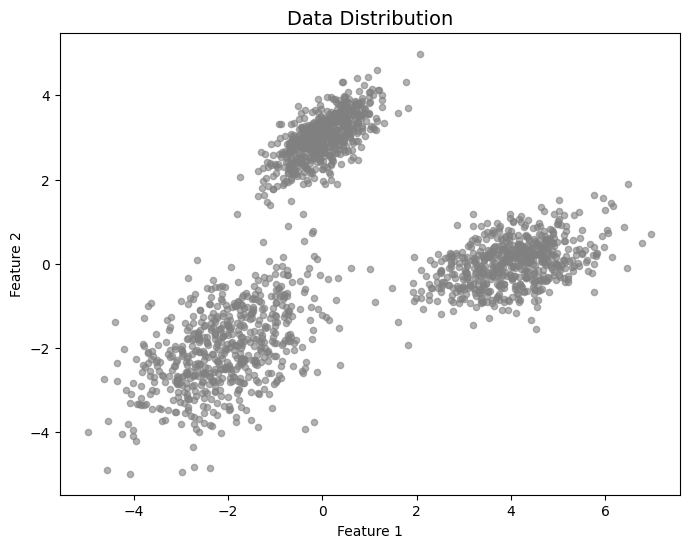

In [111]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=20, c='gray', alpha=0.6)
plt.title("Data Distribution", fontsize=14)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [119]:
class EMGaussianMixture:
    def __init__(self, n_components, max_iter=100, tol=1e-6, reg_covar=1e-6, device="cpu"):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.reg_covar = reg_covar
        self.device = device
    
    def _initialize_parameters(self, X):
        n_samples, n_features = X.shape
        indices = torch.randperm(n_samples)[:self.n_components]
        self.means_ = X[indices]
        cov = torch.cov(X.T)
        self.covariances_ = cov.unsqueeze(0).repeat(self.n_components, 1, 1)
        self.weights_ = torch.ones(self.n_components, device=self.device) / self.n_components

    def _e_step(self, X):
        n_sampels, n_features = X.shape
        weighted_pdfs = torch.zeros(n_sampels, self.n_components, device=self.device)
        for k in range(self.n_components):
            mvn = torch.distributions.MultivariateNormal(self.means_[k], self.covariances_[k]) # multivariate normal distribution
            weighted_pdfs[:, k] = self.weights_[k] * torch.exp(mvn.log_prob(X)) # weighted probability density function for each component
        sum_pdfs = weighted_pdfs.sum(dim=1, keepdim=True)
        responsibilities = weighted_pdfs / (sum_pdfs + 1e-10) # posterior probability
        return responsibilities
    
    def _m_step(self, X, resp):
        Nk = resp.sum(dim=0)
        self.weights_ = Nk / X.shape[0]
        self.means_ = (resp.T @ X) / Nk.unsqueeze(1)
        for k in range(self.n_components):
            diff = X - self.means_[k]
            weighted_diff = resp[:, k].unsqueeze(1) * diff
            self.covariances_[k] = (weighted_diff.T @ diff) / Nk[k]
            self.covariances_[k] += self.reg_covar * torch.eye(X.shape[1], device=self.device)

    def _compute_lower_bound(self, X):
        n_samples = X.shape[0]
        log_prob = torch.zeros((n_samples, self.n_components), device=self.device)
        for k in range(self.n_components):
            mvn = torch.distributions.MultivariateNormal(self.means_[k], self.covariances_[k])
            log_prob[:, k] = torch.log(self.weights_[k] + 1e-10) + mvn.log_prob(X)
        return torch.mean(torch.logsumexp(log_prob, dim=1)).item()

    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device=self.device)
        self._initialize_parameters(X)
        lower_bound_old = -float('inf')
        self.converged_ = False
        for iteration in range(self.max_iter):
            resp = self._e_step(X)
            self._m_step(X, resp)
            lower_bound_new = self._compute_lower_bound(X)
            print(f"Iter {iteration}: Lower bound = {lower_bound_new:.6f}")
            if abs(lower_bound_new - lower_bound_old) < self.tol:
                self.converged_ = True
                break
            lower_bound_old = lower_bound_new
        return self

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32, device=self.device)
        resp = self._e_step(X)
        return torch.argmax(resp, dim=1).cpu().numpy()


In [126]:
n_samples, n_features = X.shape
indices = torch.randperm(n_samples)[:3]
means_ = X[indices]
cov = torch.cov(X.T)
covariances_ = cov.unsqueeze(0).repeat(3, 1, 1)
weights_ = torch.ones(3) / 3

In [127]:
n_sampels, n_features = X.shape
weighted_pdfs = torch.zeros(n_sampels, 3)
for k in range(3):
    mvn = torch.distributions.MultivariateNormal(means_[k], covariances_[k])
    weighted_pdfs[:, k] = weights_[k] * torch.exp(mvn.log_prob(X))
sum_pdfs = weighted_pdfs.sum(dim=1, keepdim=True)
responsibilities = weighted_pdfs / (sum_pdfs + 1e-10)

In [128]:
reg_covar = 1e-6
Nk = responsibilities.sum(dim=0)
weights_ = Nk / X.shape[0]
means_ = (responsibilities.T @ X) / Nk.unsqueeze(1)
for k in range(3):
    diff = X - means_[k]
    weighted_diff = responsibilities[:, k].unsqueeze(1) * diff
    covariances_[k] = (weighted_diff.T @ diff) / Nk[k]
    covariances_[k] += reg_covar * torch.eye(X.shape[1])

In [134]:
n_samples = X.shape[0]
log_prob = torch.zeros((n_samples, 3))
for k in range(3):
    mvn = torch.distributions.MultivariateNormal(means_[k], covariances_[k])
    log_prob[:, k] = torch.log(weights_[k] + 1e-10) + mvn.log_prob(X)
torch.mean(torch.logsumexp(log_prob, dim=1)).item()

-4.184323787689209

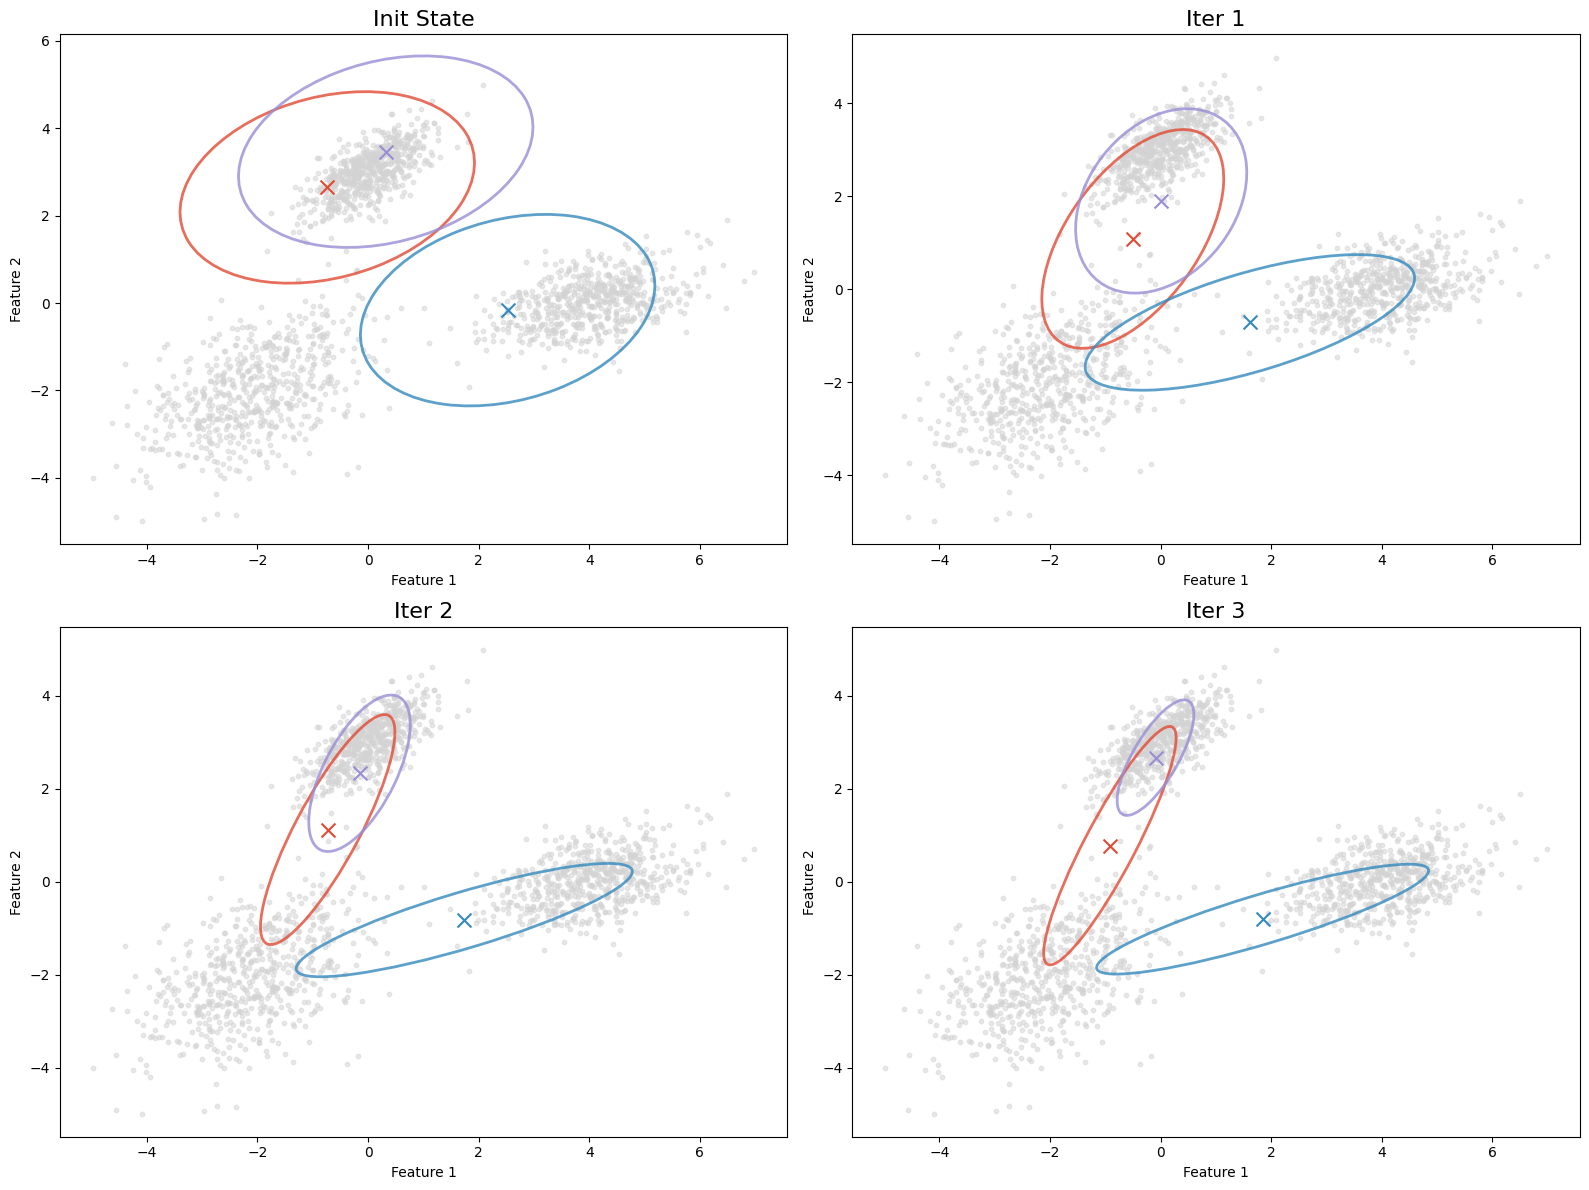

In [124]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import torch

def plot_gmm(X, means, covariances, title="GMM State", ax=None):
    means = means.cpu().numpy() if isinstance(means, torch.Tensor) else means
    covariances = covariances.cpu().numpy() if isinstance(covariances, torch.Tensor) else covariances
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(X[:, 0], X[:, 1], s=10, c='lightgray', alpha=0.5)
    colors = ['#E24A33', '#348ABD', '#988ED5', '#777777']
    for k, (mean, cov) in enumerate(zip(means, covariances)):
        ax.scatter(mean[0], mean[1], marker='x', s=100, color=colors[k % len(colors)])
        vals, vecs = np.linalg.eigh(cov)
        angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
        width, height = 2 * np.sqrt(vals)
        ell = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      edgecolor=colors[k % len(colors)], fc='None', lw=2, alpha=0.8)
        ax.add_patch(ell)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

device = 'cpu'

em = EMGaussianMixture(n_components=3, max_iter=10, device=device)
em._initialize_parameters(X)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plot_gmm(X, em.means_, em.covariances_, title="Init State", ax=axes[0, 0])

for i in range(3):
    resp = em._e_step(X_tensor)
    em._m_step(X_tensor, resp)
    plot_gmm(X, em.means_, em.covariances_, title=f"Iter {i+1}", ax=axes[(i+1)//2, (i+1)%2])

plt.tight_layout()
plt.show()